# Machine Learning for Level Truncation in Bosonic Open String Field Theory

We consider the position of lumps in bosonic open string field theory (OSFT) at mass level truncation of finite order. We then extrapolate predictions for level-$\infty$ truncation.

In this notebook we analyse the dataset using machine learning (ML) techniques. We first built a solid validation strategy trying to optimise the error as a function of the size of the training set. We then consider a few algorithms which may provide good predictions:

- [linear egression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to provide a solid baseline for the computation,
- [elastic net](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) to introduce $l_1$ and $l_2$ regularisation to weight their contribution (we could consider [lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) regression if we notice $l_1$ or $l_2$ are particularly favoured),
- [linear SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html) to introduce suppoort vectors,
- [SVR (rbf kernel)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) to use the _kernel trick_ with the dataset,
- [random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) to bag a number of decision trees,
- [XGBoost](https://xgboost.ai/) to use a flexible version of boosted trees,
- [neural networks](https://www.tensorflow.org) to introduce more complex regression functions.

## Setup

The following analysis is performed on a machine with the following specifications:

In [76]:
!echo "CPU: $(lscpu| awk '/^Model name/ {$1=""; $2=""; print}'| sed 's/^[[:space:]]*//g')"
!echo "GPU: $(lspci| awk '/3D controller/ {$1=""; $2=""; $3=""; print}'| sed 's/^[[:space:]]*//g')"
!echo "RAM: $(free --giga| awk '/^Mem/ {print $2}')GB (avail. now: $(free --giga| awk '/^Mem/ {print $7}')GB)"

CPU: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz
GPU: NVIDIA Corporation GM108M [GeForce 940MX] (rev a2)
RAM: 16GB (avail. now: 10GB)


Computations will be executed using a restricted amount of CPU threads:

In [77]:
multi_thread = 8

# sanitise the input
if multi_thread > 8:
    multi_thread = 8

We will use several module in this Python notebook. We import them early to take a look at their version number and to keep track of changes in the intallation:

In [78]:
import sys

import numpy             as np
import pandas            as pd
import matplotlib        as mpl
import matplotlib.pyplot as plt
import sklearn           as skl
import skopt             as skp
import tensorflow        as tf
import xgboost           as xgb

# Jupyter magics
%load_ext autoreload
%autoreload 2

%matplotlib inline
mpl.rc('axes', labelsize=12) #------- set size of the labels in Matplotlib
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# check for restrictions and print version number
try:
    assert np.__version__ >= '1.18.0', 'Numpy version should be at least 1.18.0 to avoid conflict with Pandas and PyTables'
    print('Numpy_version: {}'.format(np.__version__))
    
    assert pd.__version__ >= '1.0.0', 'Pandas version should be at least 1.0.0 to use PyTables correctly'
    print('Pandas version: {}'.format(pd.__version__))
    
    assert mpl.__version__ > '3.1.0', 'Matplotlib version should be at least 3.1.0'
    print('Matplotlib version: {}'.format(mpl.__version__))

    assert skl.__version__ >= '0.22.0', 'Scikit-learn version should be at least 0.22.0 to use newest implementations.'
    print('Scikit-learn version: {}'.format(skl.__version__))

    assert skp.__version__ >= '0.7.4', 'Scikit-optimize version should be at least 0.7.4 to use newest implementations.'
    print('Scikit-optimize version: {}'.format(skl.__version__))
    
    assert tf.__version__ >= '2.0.0', 'Tensorflow version should be at least 2.0.0 to use newest implementations.'
    print('Tensorflow version: {}'.format(tf.__version__))
    
    assert xgb.__version__ >= '0.88.0', 'XGBoost version should be at least 0.88.0 to use newest implementations.'
    print('XGBoost version: {}'.format(tf.__version__))
    
except AssertionError as msg:
    print(msg)
    
# fix the random seed
RAND = 42
np.random.seed(RAND)
tf.random.set_seed(RAND)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Numpy_version: 1.18.4
Pandas version: 1.0.3
Matplotlib version: 3.2.1
Scikit-learn version: 0.23.1
Scikit-optimize version: 0.23.1
Tensorflow version: 2.0.0
XGBoost version: 2.0.0


Now create the directory structure and path names to work within the notebook:

In [79]:
from os import path, makedirs

# define directory names
ROOT_DIR = '.' #-------------------------------------------------- root directory
IMG_DIR  = 'img' #------------------------------------------------ images
MOD_DIR  = 'models' #--------------------------------------------- saved models
LOG_DIR  = 'log' #------------------------------------------------ logs
OUT_DIR  = 'output' #--------------------------------------------- saved predictions, relevant output, etc.

DB_NAME = 'data_sft_analysis' #----------------------------------- name of the dataset
DB_FILE = DB_NAME + '.h5' #--------------------------------------- full name with extension
DB_PATH = path.join(ROOT_DIR, DB_FILE) #-------------------------- full path of the dataset

# define full paths
IMG_PATH = path.join(ROOT_DIR, IMG_DIR)
MOD_PATH = path.join(ROOT_DIR, MOD_DIR)
LOG_PATH = path.join(ROOT_DIR, LOG_DIR)
OUT_PATH = path.join(ROOT_DIR, OUT_DIR)

# create directories if non existent
if not path.isdir(IMG_PATH):
    makedirs(IMG_PATH, exist_ok=True)
if not path.isdir(MOD_PATH):
    makedirs(MOD_PATH, exist_ok=True)
if not path.isdir(LOG_PATH):
    makedirs(LOG_PATH, exist_ok=True)
if not path.isdir(OUT_PATH):
    makedirs(OUT_PATH, exist_ok=True)

Finally create a logging session to store debug info:

In [80]:
import logging
from mltools.liblog import create_logfile

path_to_log = path.join(LOG_PATH, DB_NAME + '.log') #--------------------------- path to the log
log = create_logfile(path_to_log, name=DB_NAME, level=logging.DEBUG) #---------- create log file and session

log.info('\n\n'
         '--------------------------------------------\n'
         '  MACHINE LEARNING FOR LEVEL TRUNCATION IN\n'
         '  BOSONIC OPEN STRING FIELD THEORY\n\n'
         '  (analysis)\n'
         '--------------------------------------------\n'
         '  Authors: Harold Erbin, Riccardo Finotello\n'
         '--------------------------------------------\n'
         '  Abstract:\n\n'
         '  We consider the position of the lumps of\n'
         '  the tachyon potential in bosonic open\n'
         '  string field theory at a finite mass level\n'
         '  truncation. We then extrapolate the\n'
         '  predictions for level-$\infty$ using\n'
         '  machine learning techniques.\n\n'
        )

Rotating existing logs...


## Importing the Database

We import the database containing the positions of the lumps of the tachyon potential:

In [81]:
if path.isfile(DB_PATH):
    df = pd.read_hdf(DB_PATH)
    
    if not df.empty:
        log.debug('Successfully imported {}'.format(DB_PATH))
    else:
        sys.stderr.write('Database is empty!')
        log.error('Database is empty!')
else:
    sys.stderr.write('Cannot find database!')

We then start to analyse the _dtypes_ of the columns to understand what the dataset is made of:

In [82]:
df.dtypes

system      int64
init      float64
weight    float64
type        int64
2         float64
3         float64
4         float64
5         float64
6         float64
7         float64
8         float64
9         float64
10        float64
11        float64
12        float64
13        float64
14        float64
15        float64
16        float64
17        float64
18        float64
exp         int64
dtype: object

Given these data types, we can have a meaningful description:

In [83]:
df.describe()

,system,init,weight,type,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,exp
count,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,...,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,7.180000e+02,718.000000
mean,23.314763,0.836629,1.981686,3.749304,-1.649589,-1.817170,7.981259,8.445939,-34.541055,-36.169106,...,-752.288433,-776.523313,3061.210057,3147.716636,-11562.460857,-11855.258680,40629.386999,41566.669584,-1.334843e+05,0.541783
std,13.023788,1.004161,2.337013,0.662688,4.548304,5.005473,21.558408,22.815235,111.039170,116.338079,...,2852.135166,2942.302665,11912.541567,12240.685674,45391.801105,46512.063723,160087.941813,163698.216993,5.278422e+05,0.706857
min,0.000000,0.000000,0.000000,2.000000,-19.744040,-21.893983,-0.754568,-0.782633,-514.984097,-538.627792,...,-13321.170445,-13781.246472,-8.850113,-12.265769,-211473.396816,-216475.644423,-44.356923,-66.596211,-2.489024e+06,-1.000000
25%,12.000000,0.000000,0.155340,4.000000,-0.819357,-1.048764,0.000000,0.000000,-0.924887,-0.941950,...,-1.122517,-2.123912,0.001518,0.001679,-3.214377,-6.185564,0.045728,0.042314,-2.569285e+01,0.000000
50%,24.000000,0.000000,1.000100,4.000000,0.000000,0.000000,0.923914,0.935052,0.000000,0.000000,...,0.001407,0.001712,0.987326,0.987066,0.001634,0.004821,1.004445,1.001084,9.732395e-02,1.000000
75%,35.000000,1.650000,3.213367,4.000000,0.795133,0.913984,1.408763,1.552803,0.960644,0.984305,...,0.991467,0.996329,4.397037,6.811820,0.997875,1.001248,16.098058,16.131990,1.003658e+00,1.000000
max,44.000000,3.000000,9.000000,4.000000,1.239384,1.358098,122.931347,131.675490,2.275741,2.712998,...,5.243298,6.283092,56115.100219,57592.698860,16.106978,23.077325,731718.332090,748286.961169,1.033588e+02,1.000000


The number of elements for each system should be rather contained and can be visualised in a histogram:

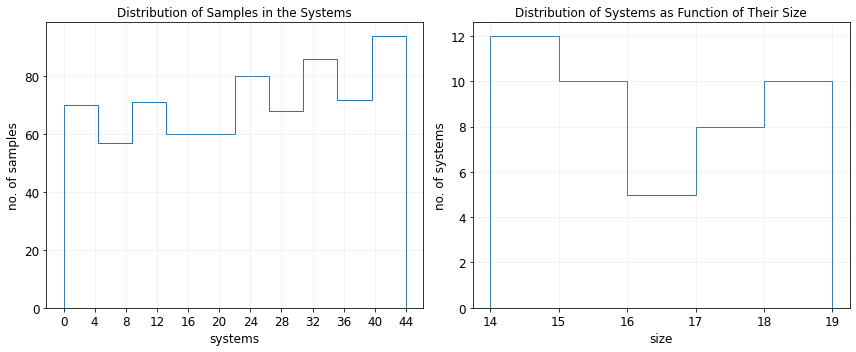

In [84]:
from mltools.libplot import Plot

hist_data = df.groupby(by=['system']).count().max(axis=1) #-------------- group by system, then count the number of elements and take a representative

plot = Plot(rows=1, columns=2)

plot.hist2D(df['system'],
            axis=0,
            title='Distribution of Samples in the Systems',
            xlabel='systems',
            ylabel='no. of samples',
            binstep=4
           )

plot.hist2D(hist_data,
            axis=1,
            title='Distribution of Systems as Function of Their Size',
            xlabel='size',
            ylabel='no. of systems',
            bins=range(hist_data.min(), hist_data.max() + 1, 1)
           )

plot.save_and_close(path.join(IMG_PATH, 'distribution'))
log.debug('Saved distribution plot.')

## Test Set Selection

We split the training set into a test and training sets keeping samples of the same system in the same set. As our dataset is quite small, we will try to keep around 20% of data in the test set to keep a good predictive ability.

We first divide features from labels (in the features, we also drop the `init` column as we are not interested in using the initial values for the learning algorithms and the `system` column which will only be used to split training and test sets).

In [85]:
df = df.sample(frac=1, random_state=RAND) #-------------------------------------------------- first shuffle the dataset

log.debug('Database has been shuffled.')

We then split the dataset using the `system` label:

In [86]:
from sklearn.model_selection import train_test_split

train_system, test_system = train_test_split(df['system'].unique(), test_size=0.2, shuffle=False)

This leads to training and test set with the following shapes:

In [87]:
df_train = df.loc[df['system'].isin(train_system)]
df_test  = df.loc[df['system'].isin(test_system)]

# print the shape
print('Training set size: {:d} ({:.1f}% of the total dataset)'.format(df_train.shape[0], 100 * df_train.shape[0] / df.shape[0]))
print('Test set size:     {:d} ({:.1f}% of the total dataset)'.format(df_test.shape[0], 100 * df_test.shape[0] / df.shape[0]))

Training set size: 580 (80.8% of the total dataset)
Test set size:     138 (19.2% of the total dataset)


## Validation Strategy

For the same reason we used the `system` column to choose the training and test sets, we also need to use the same strategy for the validation set. Given the restricted size of the training dataset, we use a single _development set_ whose size must be decided. We use a linear regression to plot the error on the validation set as a function of the size of the development set. We clearly use the same approach as before: we take the `system` label, split the training set accordingly, fit the training data and evaluate on the development set.

In foresight of what we are going to do, we also apply a standardization to the training data.

In [88]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model  import LinearRegression
from sklearn.metrics       import mean_squared_error



# devide what development set sizes to explore
dev_sizes = np.arange(0.15, 0.95, 0.05)

# save results in an array (made of [dev set size, mse] for each sample: shape = (dev_sizes.shape[0], 2))
results = np.zeros((dev_sizes.shape[0], 2))

# explore each dev size
for n in range(dev_sizes.shape[0]):
    
    # separate train and dev systems values
    train_system, dev_system = train_test_split(df_train['system'].unique(), test_size=dev_sizes[n], shuffle=False)

    # separate train and dev sets
    df_train_tmp = df_train.loc[df_train['system'].isin(train_system)].drop(columns=['system', 'init'])
    df_dev_tmp   = df_train.loc[df_train['system'].isin(dev_system)].drop(columns=['system', 'init'])

    # compute the size of the dev set w.r.t. the training set (it can differ from the size selected with the 'system' label)
    dev_set_size = df_dev_tmp.shape[0] / df_train.shape[0]

    # separate features from labels
    X_train, y_train = df_train_tmp.drop(columns='exp'), df_train_tmp['exp']
    X_dev,   y_dev   = df_dev_tmp.drop(columns='exp'),   df_dev_tmp['exp']

    # standardize the features
    std = StandardScaler()

    X_train = std.fit_transform(X_train)
    X_dev   = std.transform(X_dev)

    # compute the linear regression
    est = LinearRegression(fit_intercept=True, n_jobs=multi_thread)
    est.fit(X_train, y_train)

    # compute the predictions on the development set
    y_dev_pred = est.predict(X_dev)

    # compute the MSE on the predictions
    mse = mean_squared_error(y_dev, y_dev_pred)

    # save the results in the list
    results[n,:] = (dev_set_size, mse)

We then plot the results of the study:

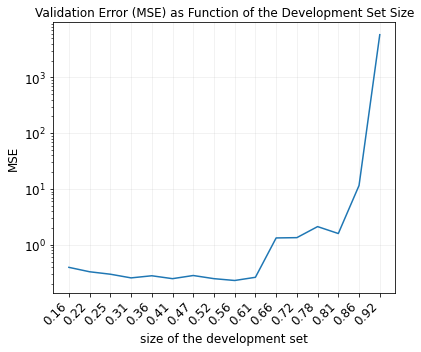

In [89]:
Plot().series2D(results[:,1],
                title='Validation Error (MSE) as Function of the Development Set Size',
                xlabel='size of the development set',
                ylabel='MSE',
                ylog=True,
                labels=np.around(results[:,0], decimals=2)
               ).save_and_close(path.join(IMG_PATH, 'val_error'))

log.debug('Saved validation error plot.')

It seems that a good compromise between the number of samples and the validation error might be around 25% of the training set. We therefore select that value as a reference to split definitely the set:

In [90]:
# get the index of the 'results' vector which is closer the desired quantity and take the corresponding 'dev_sizes' position
[dev_size] = dev_sizes[np.where(np.isclose(results[:,0], 0.25, atol=0.01))]

# split the datasets
train_system, dev_system = train_test_split(df_train['system'].unique(), test_size=dev_size, shuffle=False)
train_split = df_train.loc[df_train['system'].isin(train_system)].drop(columns=['system', 'init'])
dev_split   = df_train.loc[df_train['system'].isin(dev_system)].drop(columns=['system', 'init'])
test_split  = df_test.drop(columns=['system', 'init'])

# compute train, dev and test sizes
print('Training set size:    {:.1f}%'.format(100 * train_split.shape[0] / df.shape[0]))
print('Development set size: {:.1f}%'.format(100 * dev_split.shape[0] / df.shape[0]))
print('Test set size:        {:.1f}%'.format(100 * test_split.shape[0] / df.shape[0]))

# divide features and labels
X_train, y_train = train_split.drop(columns='exp'), train_split['exp'].values.reshape(-1,1)
X_dev,   y_dev   = dev_split.drop(columns='exp'),   dev_split['exp'].values.reshape(-1,1)
X_test,  y_test  = test_split.drop(columns='exp'),  test_split['exp'].values.reshape(-1,1)

# apply the standardization
std     = StandardScaler()
X_train = std.fit_transform(X_train)
X_dev   = std.transform(X_dev)
X_test  = std.transform(X_test)

Training set size:    60.7%
Development set size: 20.1%
Test set size:        19.2%


## Machine Learning Analysis

We can now start to implement the regression algorithms we are trying to study. In general we use Bayes optimisation to tune the hyperparameters of the algorithm (exception made for linear regression: we will use a grid search) trying to minimise the mean squared error loss function.

For each algorithm we will try to output several metrics, even though we will only use the MSE to score the algorithm:

- _mean squared error_:
\begin{equation}
\mathrm{MSE}( y_{true}, y_{pred} ) = \frac{1}{N} \sum\limits_{i = 1}^N \left( y^{(i)}_{true} - y^{(i)}_{pred} \right) ^2,
\end{equation}

- _$R^2$ score_:
\begin{equation}
\mathrm{R}^2( y_{true}, y_{pred} ) = 1 - \frac{\sum\limits_{i = 1}^N \left( y^{(i)}_{true} - y^{(i)}_{pred} \right)^2}{\sum\limits_{i = 1}^N \left( y^{(i)}_{true} - \bar{y}_{pred} \right)^2}
\end{equation}
where
\begin{equation}
\bar{y}_{pred} = \frac{1}{N} \sum\limits_{i = 1}^N y^{(i)}_{true},
\end{equation}

- _explained variance score_:
\begin{equation}
\mathrm{EVar}( y_{true}, y_{pred} ) = 1 - \frac{\mathrm{Var}\{ y_{true} - y_{pred} \}}{\mathrm{Var}\{ y_{true} \}}.
\end{equation}

We will also compute the confidence interval of the variance: this represents the the range of values for which we have confidence that the variance estimated from the data is a good representative of the true error. We therefore fix here the confidence we are trying to achieve:

In [91]:
confidence = 0.95 #--- usually we set 95% of the variance (lower values are stricter)

### Linear Regression

We now consider a simple linear regression whose only hyperparameter is `fit_intercept` $\in \lbrace 0, 1 \rbrace$:

In [92]:
import json

from sklearn.linear_model import LinearRegression
from sklearn.metrics      import mean_squared_error, explained_variance_score, r2_score

# define the grid search
fit_intercept = np.array([False, True]).reshape(-1,1)

# define a vector of results with a shape (fit_intercept.shape[0], 3), where 3 is the number of metrics used
results = np.zeros((fit_intercept.shape[0], 3))

# define the estimator (set normalize to False since we already added standardization)
lin_reg = LinearRegression(normalize=False, n_jobs=multi_thread)
log.info('Fitting linear regression.')

# loop over the hyperparameter optimisation space and save the results in a dictionary
opt_results = {'fit_intercept': [],
               'mse':           [],
               'r2':            [],
               'evar':          []
              }
for n in range(fit_intercept.shape[0]):
    
    # insert hyperparameter in the estimator
    lin_reg.set_params(**{'fit_intercept': fit_intercept[n,:]})

    # fit the estimator
    lin_reg.fit(X_train, y_train)

    # generate predictions on the validation set
    y_dev_pred = lin_reg.predict(X_dev)

    # compute metrics
    mse  = mean_squared_error(y_dev, y_dev_pred) #---------- compute MSE
    r2   = r2_score(y_dev, y_dev_pred) #-------------------- compute R2
    evar = explained_variance_score(y_dev, y_dev_pred) #---- compute explained variance
    results[n,:] = (mse, r2, evar) #------------------------ add to the results
    
    # save to dictionary
    opt_results['fit_intercept'].append(fit_intercept[n,:].squeeze().tolist())
    opt_results['mse'].append(mse)
    opt_results['r2'].append(r2)
    opt_results['evar'].append(evar)
    
# look for the best results
best_arg     = np.argmin(results[:,0])
best_results = results[best_arg,:].reshape(-1,1)
best_params  = fit_intercept[best_arg,:].reshape(-1,1)

# retrain over the training set with the best parameters
lin_reg.set_params(**{'fit_intercept': fit_intercept[best_arg,:]})
lin_reg.fit(X_train, y_train)

# generate predictions on the dev set
y_dev_pred = lin_reg.predict(X_dev).reshape(-1,1)

# print the best results
print('Results for LINEAR REGRESSION:\n\n'
      '  Best parameters:\n\n'
      '    fit_intercept: {}\n\n'
      '  MSE:  {:.3f}\n'
      '  R2:   {:.3f}\n'
      '  EVAR: {:.3f}'
      .format(best_params[0,:].squeeze(),
              best_results[0,:].squeeze(),
              best_results[1,:].squeeze(),
              best_results[2,:].squeeze()
             )
     )

# save results to file
with open(path.join(OUT_PATH, 'lin_reg_dev_opt_res.json'), 'w') as f:
    json.dump(opt_results, f)
    log.debug('Linear regression optimisation results (dev set) saved to file.')

Results for LINEAR REGRESSION:

  Best parameters:

    fit_intercept: True

  MSE:  0.297
  R2:   0.404
  EVAR: 0.408


The confidence interval can be estimated using a Student's $t$-distribution:

In [93]:
from scipy import stats

def confidence_interval(y_true, y_pred, confidence=0.95):
    '''
    Compute the confidence interval of the variance.
    
    Required arguments:
        y_true: true values,
        y_pred: predictions.
        
    Returns:
        the array of lower and upper bounds of the confidence interval.
    '''
    
    # compute the deviation of the data and the squared errors
    deviation = y_pred - y_true #-------------------------------------- > 0 if overestimating, < 0 if underestimating
    sq_errors = deviation ** 2 #--------------------------------------- squared errors

    conf_interval = stats.t.interval(confidence,
                                     sq_errors.shape[0] - 1,
                                     loc=sq_errors.mean(),
                                     scale=stats.sem(sq_errors)
                                    ) #-------------------------------- compute the confidence interval
    
    return conf_interval

conf_interval = confidence_interval(y_dev, y_dev_pred, confidence=confidence)
print('Confidence interval: [ {:.3f}, {:.3f} ]'.format(conf_interval[0].squeeze(), conf_interval[1].squeeze()))

Confidence interval: [ 0.095, 0.499 ]


We then save the model and its predictions for later use:

In [94]:
import joblib

def save_res(short_name):
    '''
    Save results to file.
    
    Required arguments:
        short_name: a short identifier of the estimator considered.
    '''
    # save the model to file
    joblib.dump(lin_reg, path.join(MOD_PATH, short_name + '.joblib.xz'), compress=('xz', 9))

    # save predictions to file
    dev_predictions = {'y_dev_true': y_dev.squeeze().tolist(),
                       'y_dev_pred': y_dev_pred.squeeze().tolist(),
                       'y_dev_err':  (y_dev_pred - y_dev).squeeze().tolist()
                      }
    with open(path.join(OUT_PATH, short_name + '_dev_preds.json'), 'w') as f:
        json.dump(dev_predictions, f)

save_res('lin_reg')
log.debug('Linear regression results (dev set) saved to file.')

We can also plot the absolute deviation of the predictions in various ways:

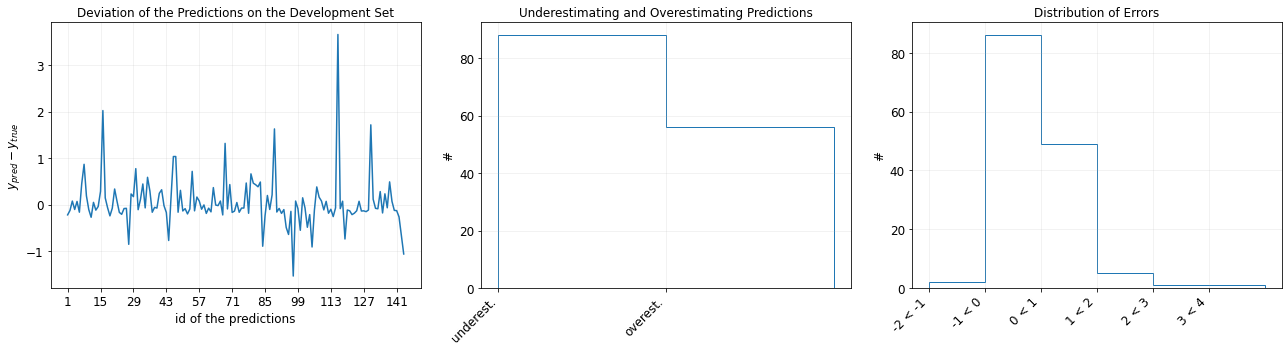

In [95]:
from sklearn.preprocessing import Binarizer

def error_visualisation(y_true, y_pred):
    '''
    Visualise plots of the variance of the errors.
    
    Required arguments:
        y_true: true values,
        y_pred: predictions.
        
    Returns:
        the Matplotlib axis with the plots.
    '''
    # compute useful quantities
    deviation    = y_pred - y_true #----------------------------------------------- > 0 if overestimating, < 0 if underestimating
    binarization = Binarizer(threshold=0.0).transform(deviation) #----------------- +1 if overestimating, 0 if underestimating
    digit_bins   = range(int(np.ceil(deviation.min())),
                         int(np.ceil(deviation.max())) + 1
                        ) #-------------------------------------------------------- define the bins to discretize the deviation
    digitization = np.digitize(deviation, 
                               bins=digit_bins
                              ) #-------------------------------------------------- discretize deviation into unit bins

    # plot the results
    plot = Plot(rows=1, columns=3)

    plot.series2D(deviation,
                  axis=0,
                  title='Deviation of the Predictions on the Development Set',
                  xlabel='id of the predictions',
                  ylabel='$y_{pred} - y_{true}$',
                  binstep=14
                 )

    plot.hist2D(binarization,
                axis=1,
                title='Underestimating and Overestimating Predictions',
                ylabel='#',
                bins=[0,1,2],
                labels=['underest.', 'overest.']
               )

    plot.hist2D(digitization,
                axis=2,
                title='Distribution of Errors',
                ylabel='#',
                bins=range(len(digit_bins)+1),
                labels=['{} < {}'.format(n-1, n) for n in digit_bins]
               )
    
    return plot

plot = error_visualisation(y_dev, y_dev_pred)
plot.save_and_close(path.join(IMG_PATH, 'lin_reg_errors'))
log.debug('Linear regression plot saved.')

Using linear regression we therefore see that:

- even though the MSE seems good, the variance has a very large confidence interval,
- in general linear regression seems to underestimate the true values,
- the distribution of the errors is peaked but in any case spread across a larger number of values,
- the $R^2$ and explained variance are similar but far from good.

### Elastic Net

We now consider the linear regression in the presence of $l_1$ and $l_2$ regularisation. We will need to study the hyperparameter space given by the choice of `fit_intercept` as in the linear regression, but also `alpha` and `l1-ratio` which control the regularisation: `alpha` $\times$ `l1_ratio` is the magnitude of the $l_1$ regularisation, while `alpha` $\times (1 -$ `l1_ratio` $) / 2$ controls the $l_2$ regularisation.

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics      import mean_squared_error, explained_variance_score, r2_score
from skopt                import gp_minimize
from skopt.space          import Real, Integer
from skopt.utils          import use_named_args

# define the hyperparameter search space
hyp_names  = ['fit_intercept', 'alpha', 'l1_ratio']
hyp_search = [Integer(0, 1, name=hyp_names[0]),
              Real(1.0e-7, 1.0e-4, prior='log-uniform', name=hyp_names[1]),
              Real(0.0, 1.0, name=hyp_names[2])
             ]

# define the number of iterations of the optimisation
n_calls    = 10

# define the estimator
el_net = ElasticNet(normalize=False, #------------------------ keep normalize = 0 since we already standardize the features
                    max_iter=1e8,
                    tol=1.0e-3,
                    random_state=RAND
                   )

# define the objective function
@use_named_args(hyp_search)
def objective(**params):
    '''
    Compute the mean squared error on the validation set.
    
    Required arguments:
        **params:  the hyperparameters search space.
        
    Returns:
        the mean squared error of the dev set.
    '''
    
    # fit the estimator to the train set
    el_net.set_params(**params)
    el_net.fit(X_train, y_train)
    
    # compute predictions on the dev set
    y_dev_pred = el_net.predict(X_dev).reshape(-1,1)
    
    # compute the mean squared error
    return mean_squared_error(y_dev, y_dev_pred)

# save the results of the optimisation
el_net_res = gp_minimize(objective, hyp_search, n_calls=n_calls, random_state=RAND, n_jobs=multi_thread)
skp.dump(el_net_res, path.join(OUT_PATH, 'el_net_dev_opt_res.pkl'))
log.debug('Elastic net optimisation results (dev set) saved to file.')

We the print the results and compute the metrics:

In [ ]:
# retrieve best results, fit to the training set and print
el_net.set_params(**dict(zip(hyp_names, el_net_res.x))) #----- set parameters to best possible choice
el_net.fit(X_train, y_train) #-------------------------------- fit again on the training set
y_dev_pred = el_net.predict(X_dev).reshape(-1,1) #------------ compute predictions

print('Results for ELASTIC NET:\n')
print('  Best parameters:\n')
for name, value in zip(hyp_names, el_net_res.x):
    print('    {}: {}'.format(name, value))
    
print('\n  MSE:  {:.3f}'.format(mean_squared_error(y_dev, y_dev_pred)))
print('  R2:   {:.3f}'.format(r2_score(y_dev, y_dev_pred)))
print('  EVAR: {:.3f}'.format(explained_variance_score(y_dev, y_dev_pred)))

Results can then be completed by computing the confidence interval:

In [ ]:
conf_interval = confidence_interval(y_dev, y_dev_pred, confidence=confidence)
print('Confidence interval: [ {:.3f}, {:.3f} ]'.format(conf_interval[0].squeeze(), conf_interval[1].squeeze()))

We then save the results to file:

In [ ]:
save_res('el_net')
log.debug('Elastic net results (dev set) saved to file.')

Finally we visualise the distribution of the variance of the errors in plots:

In [ ]:
plot = error_visualisation(y_dev, y_dev_pred)
plot.save_and_close(path.join(IMG_PATH, 'el_net_errors'))
log.debug('Elastic net plot saved.')

With the introduction of regularisation we find:

- in general the MSE is worse, and the confidence interval seems to be larger,
- errors are in general underestimating, but they are confined in a smaller range,
- overestimating errors tend to have larger absolute deviations,
- $R^2$ and explained variance are again similar but worse than the simple linear regression,
- the algorithm seems to prefer a very small $l_1$ regularization (any an almost vanishing $l_2$ regularisation).

### Lasso

Given the results of the elastic net, we implement the lasso regression which a pure $l_1$ regularisation. We will therefore control only one hyperparameter `alpha` which represents the magnitude of the regularisation.

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics      import mean_squared_error, explained_variance_score, r2_score
from skopt                import gp_minimize
from skopt.space          import Real, Integer
from skopt.utils          import use_named_args

# define the hyperparameter search space
hyp_names  = ['fit_intercept', 'alpha']
hyp_search = [Integer(0, 1, name=hyp_names[0]),
              Real(1.0e-5, 1.0e-2, prior='log-uniform', name=hyp_names[1])
             ]

# define the number of iterations of the optimisation
n_calls    = 10

# define the estimator
lasso = Lasso(normalize=False, #------------------------ keep normalize = 0 since we already standardize the features
              max_iter=1e8,
              tol=1.0e-3,
              random_state=RAND
             )

# define the objective function
@use_named_args(hyp_search)
def objective(**params):
    '''
    Compute the mean squared error on the validation set.
    
    Required arguments:
        **params:  the hyperparameters search space.
        
    Returns:
        the mean squared error of the dev set.
    '''
    
    # fit the estimator to the train set
    lasso.set_params(**params)
    lasso.fit(X_train, y_train)
    
    # compute predictions on the dev set
    y_dev_pred = lasso.predict(X_dev).reshape(-1,1)
    
    # compute the mean squared error
    return mean_squared_error(y_dev, y_dev_pred)

# save the results of the optimisation
lasso_res = gp_minimize(objective, hyp_search, n_calls=n_calls, random_state=RAND, n_jobs=multi_thread)
skp.dump(lasso_res, path.join(OUT_PATH, 'lasso_dev_opt_res.pkl'))
log.debug('Lasso optimisation results (dev set) saved to file.')

We the print the results and compute the metrics:

In [ ]:
# retrieve best results, fit to the training set and print
lasso.set_params(**dict(zip(hyp_names, lasso_res.x))) #----- set parameters to best possible choice
lasso.fit(X_train, y_train) #-------------------------------- fit again on the training set
y_dev_pred = lasso.predict(X_dev).reshape(-1,1) #------------ compute predictions

print('Results for LASSO:\n')
print('  Best parameters:\n')
for name, value in zip(hyp_names, lasso_res.x):
    print('    {}: {}'.format(name, value))
    
print('\n  MSE:  {:.3f}'.format(mean_squared_error(y_dev, y_dev_pred)))
print('  R2:   {:.3f}'.format(r2_score(y_dev, y_dev_pred)))
print('  EVAR: {:.3f}'.format(explained_variance_score(y_dev, y_dev_pred)))

Results can then be completed by computing the confidence interval:

In [ ]:
conf_interval = confidence_interval(y_dev, y_dev_pred, confidence=confidence)
print('Confidence interval: [ {:.3f}, {:.3f} ]'.format(conf_interval[0].squeeze(), conf_interval[1].squeeze()))

We then save the results to file:

In [ ]:
save_res('lasso')
log.debug('Lasso results (dev set) saved to file.')

Finally we visualise the distribution of the variance of the errors in plots:

In [ ]:
plot = error_visualisation(y_dev, y_dev_pred)
plot.save_and_close(path.join(IMG_PATH, 'lasso_errors'))
log.debug('Lasso plot saved.')

Given the elastic net regression, we introduced just the $l_1$ regularised version of linear regression:

- we find the same scores as for the elastic net ($l_2$ regularisation does not influence the results),
- the confidence interval is the same as in the elastic net,
- underestimating errors are restricted to a small interval, while overestimating errors are in general spread across several values.

All in all, it seems that adding the regularisation is not helping.

### Linear SVR

We now study the support vector machine without using the kernel trick. We will therefore control a wider range of possible hyperparameters mainly related to the _soft margin_ implementation of SVR for regression.

In [ ]:
from sklearn.svm     import LinearSVR
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from skopt           import gp_minimize
from skopt.space     import Real, Integer, Categorical
from skopt.utils     import use_named_args

# define the hyperparameter search space
hyp_names  = ['fit_intercept', 'epsilon', 'C', 'loss', 'intercept_scaling']
hyp_search = [Integer(0, 1, name=hyp_names[0]),
              Real(1.0e-9, 1.0e-2, prior='log-uniform', name=hyp_names[1]),
              Real(1.0e-4, 1.0e1, prior='log-uniform', name=hyp_names[2]),
              Categorical(['epsilon_insensitive', 'squared_epsilon_insensitive'], name=hyp_names[3]),
              Real(1.0e-3, 1.0e1, prior='log-uniform', name=hyp_names[4])
             ]

# define the number of iterations of the optimisation
n_calls    = 10

# define the estimator
lin_svr = LinearSVR(dual=True,
                    max_iter=1e6,
                    random_state=RAND
                   )

# define the objective function
@use_named_args(hyp_search)
def objective(**params):
    '''
    Compute the mean squared error on the validation set.
    
    Required arguments:
        **params:  the hyperparameters search space.
        
    Returns:
        the mean squared error of the dev set.
    '''
    
    # fit the estimator to the train set
    lin_svr.set_params(**params)
    lin_svr.fit(X_train, y_train.ravel())
    
    # compute predictions on the dev set
    y_dev_pred = lin_svr.predict(X_dev).reshape(-1,1)
    
    # compute the mean squared error
    return mean_squared_error(y_dev, y_dev_pred)

# save the results of the optimisation
lin_svr_res = gp_minimize(objective, hyp_search, n_calls=n_calls, random_state=RAND, n_jobs=multi_thread)
skp.dump(lin_svr_res, path.join(OUT_PATH, 'lin_svr_dev_opt_res.pkl'))
log.debug('Linear SVR optimisation results (dev set) saved to file.')

We the print the results and compute the metrics:

In [ ]:
# retrieve best results, fit to the training set and print
lin_svr.set_params(**dict(zip(hyp_names, lin_svr_res.x))) #---- set parameters to best possible choice
lin_svr.fit(X_train, y_train.ravel()) #------------------------ fit again on the training set
y_dev_pred = lin_svr.predict(X_dev).reshape(-1,1) #------------ compute predictions

print('Results for LINEAR SVR:\n')
print('  Best parameters:\n')
for name, value in zip(hyp_names, lin_svr_res.x):
    print('    {}: {}'.format(name, value))
    
print('\n  MSE:  {:.3f}'.format(mean_squared_error(y_dev, y_dev_pred)))
print('  R2:   {:.3f}'.format(r2_score(y_dev, y_dev_pred)))
print('  EVAR: {:.3f}'.format(explained_variance_score(y_dev, y_dev_pred)))

Results can then be completed by computing the confidence interval:

In [ ]:
conf_interval = confidence_interval(y_dev, y_dev_pred, confidence=confidence)
print('Confidence interval: [ {:.3f}, {:.3f} ]'.format(conf_interval[0].squeeze(), conf_interval[1].squeeze()))

We then save the results to file:

In [ ]:
save_res('lin_svr')
log.debug('Linear SVR results (dev set) saved to file.')

Finally we visualise the distribution of the variance of the errors in plots:

In [ ]:
plot = error_visualisation(y_dev, y_dev_pred)
plot.save_and_close(path.join(IMG_PATH, 'lin_svr_errors'))
log.debug('Linear SVR plot saved.')

It seems that the support vectors without the kernel trick do not improve the situation seen with the linear regression:

- we find the same scores as for the elastic net,
- the confidence interval is more restricted, signalling in any case a better convergence of the values,
- underestimating errors are restricted to a small interval, while overestimating errors are in general spread across several values.

### SVR (Gaussian kernel)

We then focus on SVR with the kernel trick: we consider a Gaussian kernel (_rbf_) and implement the analysis.

In [71]:
from sklearn.svm     import SVR
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from skopt           import gp_minimize
from skopt.space     import Real, Integer, Categorical
from skopt.utils     import use_named_args

# define the hyperparameter search space
hyp_names  = ['gamma', 'epsilon', 'C']
hyp_search = [Real(1.0e-3, 1.0e-1, prior='log-uniform', name=hyp_names[0]),
              Real(1.0e-9, 1.0e-2, prior='log-uniform', name=hyp_names[1]),
              Real(1.0e-4, 1.0e1, prior='log-uniform', name=hyp_names[2])
             ]

# define the number of iterations of the optimisation
n_calls    = 10

# define the estimator
svr_rbf = SVR(kernel='rbf')

# define the objective function
@use_named_args(hyp_search)
def objective(**params):
    '''
    Compute the mean squared error on the validation set.
    
    Required arguments:
        **params:  the hyperparameters search space.
        
    Returns:
        the mean squared error of the dev set.
    '''
    
    # fit the estimator to the train set
    svr_rbf.set_params(**params)
    svr_rbf.fit(X_train, y_train.ravel())
    
    # compute predictions on the dev set
    y_dev_pred = svr_rbf.predict(X_dev).reshape(-1,1)
    
    # compute the mean squared error
    return mean_squared_error(y_dev, y_dev_pred)

# save the results of the optimisation
svr_rbf_res = gp_minimize(objective, hyp_search, n_calls=n_calls, random_state=RAND, n_jobs=multi_thread)
skp.dump(svr_rbf_res, path.join(OUT_PATH, 'svr_rbf_dev_opt_res.pkl'))
log.debug('SVR optimisation results (dev set) saved to file.')

/home/riccardo/anaconda/envs/ml/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/riccardo/anaconda/envs/ml/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


We the print the results and compute the metrics:

In [72]:
# retrieve best results, fit to the training set and print
svr_rbf.set_params(**dict(zip(hyp_names, svr_rbf_res.x))) #---- set parameters to best possible choice
svr_rbf.fit(X_train, y_train.ravel()) #------------------------ fit again on the training set
y_dev_pred = svr_rbf.predict(X_dev).reshape(-1,1) #------------ compute predictions

print('Results for SVR (rbf kernel):\n')
print('  Best parameters:\n')
for name, value in zip(hyp_names, svr_rbf_res.x):
    print('    {}: {}'.format(name, value))
    
print('\n  MSE:  {:.3f}'.format(mean_squared_error(y_dev, y_dev_pred)))
print('  R2:   {:.3f}'.format(r2_score(y_dev, y_dev_pred)))
print('  EVAR: {:.3f}'.format(explained_variance_score(y_dev, y_dev_pred)))

Results for SVR (rbf kernel):

  Best parameters:

    gamma: 0.1
    epsilon: 0.01
    C: 10.0

  MSE:  0.153
  R2:   0.693
  EVAR: 0.710


Results can then be completed by computing the confidence interval:

In [73]:
conf_interval = confidence_interval(y_dev, y_dev_pred, confidence=confidence)
print('Confidence interval: [ {:.3f}, {:.3f} ]'.format(conf_interval[0].squeeze(), conf_interval[1].squeeze()))

Confidence interval: [ 0.060, 0.246 ]


We then save the results to file:

In [74]:
save_res('svr_rbf')
log.debug('SVR results (dev set) saved to file.')

Finally we visualise the distribution of the variance of the errors in plots:

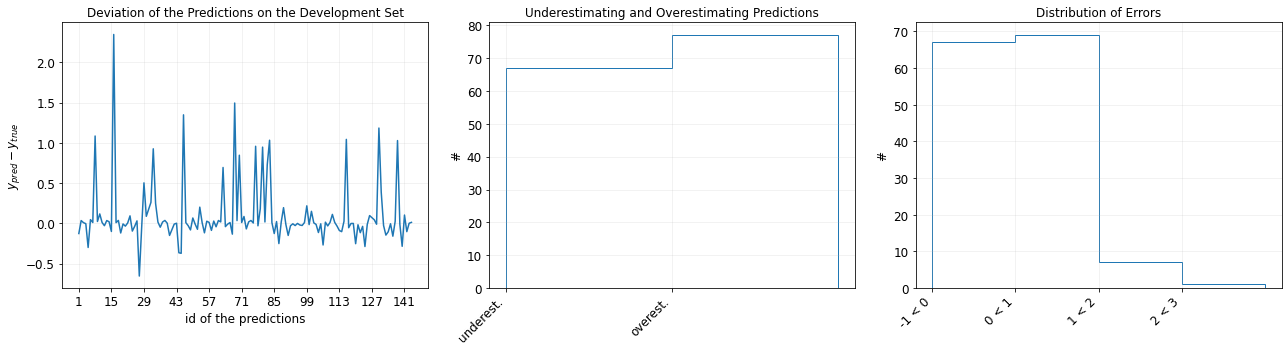

In [75]:
plot = error_visualisation(y_dev, y_dev_pred)
plot.save_and_close(path.join(IMG_PATH, 'svr_rbf_errors'))
log.debug('SVR plot saved.')

The introduction of the kernel trick seems to drastically improve the situation:

- the value of the MSE is significantly reduces and the $R^2$ and explained variance show a better results,
- the confidence interval peaked around the value of the MSE,
- underestimating and overestimating errors seem to be balanced and restricted to smaller intervals.